In [1]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.5 MB 1.4 MB/s 


In [2]:
import cv2
import mediapipe as mp
import math
import os

from google.colab.patches import cv2_imshow
# import dependencies
from IPython.display import display, Javascript, Image
from keras.models import Model, save, load_model
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

# **JavaScript Part for Accessing WebCam in Google Colab**

In [3]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [4]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# **Finding Hand in Video Stream**

In [5]:
class HandDetector:


    def __init__(self, mode=False, maxHands=1, detectionCon=0.5, minTrackCon=0.5):

        self.mpHands = mp.solutions.hands
        self.hands = self.mpHands.Hands(static_image_mode=False, max_num_hands=maxHands,
                                                min_detection_confidence=detectionCon,
                                                min_tracking_confidence=minTrackCon)
        

    def findHands(self, img, draw=True, flipType=True):

            res = []


            imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            results = self.hands.process(imgRGB)
            allHands = []
            h, w, c = img.shape
            if results.multi_hand_landmarks:
                for handType, handLms in zip(results.multi_handedness, results.multi_hand_landmarks):

                    ## lmList
                    mylmList = []
                    xList = []
                    yList = []
                    for id, lm in enumerate(handLms.landmark):
                        px, py, pz = int(lm.x * w), int(lm.y * h), int(lm.z * w)
                        mylmList.append([px, py, pz])
                        xList.append(px)
                        yList.append(py)

                    ## bbox
                    xmin, xmax = min(xList), max(xList)
                    ymin, ymax = min(yList), max(yList)
                    boxW, boxH = xmax - xmin, ymax - ymin
                    bbox = xmin, ymin, boxW, boxH

                    if draw:
                        res.append(bbox)

            if draw:
                return res

# **Loading Model**

In [6]:
model = load_model("/content/drive/MyDrive/IEEE_Project/gesture_model.h5")

In [ ]:
model.summary()

# **Functions To Perform Specific Task**

In [8]:
def open_web():
    url = 'https://www.google.com/'
    display(Javascript('window.open("{url}");'.format(url=url)))



def show_pic() :
    img = cv2.imread('/content/drive/MyDrive/IEEE_Project/Ferrari.jpg')
    img = cv2. resize(img, (240, 240))
    cv2_imshow(img)


def make_folder() :
    !mkdir /content/drive/MyDrive/IEEE_Project/sample


# **Testing**

<IPython.core.display.Javascript object>

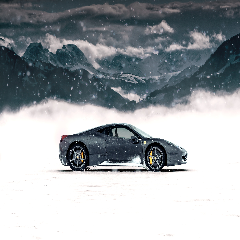

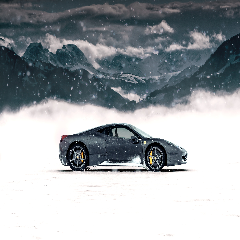

<IPython.core.display.Javascript object>

mkdir: cannot create directory ‘/content/drive/MyDrive/IEEE_Project/sample’: File exists
mkdir: cannot create directory ‘/content/drive/MyDrive/IEEE_Project/sample’: File exists


In [12]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''

detector = HandDetector()

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    
    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    hand = detector.findHands(img)

    if hand :

        for (x,y,w,h) in hand:
            bbox_array = cv2.rectangle(bbox_array,(x-20,y-20),(x+w+20,y+h+20),(255,0,0),2)

            ci = img[y:y+h+20, x:x+w+20]
            ci = cv2.resize(ci, (224, 224))


        ci = cv2.resize(ci, (224, 224), interpolation = cv2.INTER_LINEAR)
        ci = ci / 255.
        ci = ci.reshape(1,224,224,3) 

        res = np.argmax(model.predict(ci), axis=1)

        if res[0] == 1 :
            bbox_array = cv2.putText(bbox_array, "Image", (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
            show_pic()
        elif res[0] == 2 :
            bbox_array = cv2.putText(bbox_array, "Folder Created", (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
            make_folder()
        elif res[0] == 3 :
            bbox_array = cv2.putText(bbox_array, "OpenSite", (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
            open_web()

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes